# Recommendation Model with KNN

In [2]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def spotify(client_id, client_secret):
    # Authenticate
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    return sp

# Set up the credentials
with open('config.json') as config_file:
    config = json.load(config_file)

client_id = config['client_id']['0']
client_secret = config['client_secret']['0']

sp = spotify(client_id, client_secret)

## My Spotify Playlist which we are going to use to train the data

In [3]:
df = pd.read_csv("my_songs.csv")
df

,Unnamed: 0,playlist,id,name,genre,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,0,Its time,2FoahzOSxJnalPA8aBUme3,all of me,Rap,0.652,0.80600,5,-5.707,0,...,0.000011,0.8420,0.779,159.947,audio_features,spotify:track:2FoahzOSxJnalPA8aBUme3,https://api.spotify.com/v1/tracks/2FoahzOSxJna...,https://api.spotify.com/v1/audio-analysis/2Foa...,198293,4
1,1,Its time,6x9pCndnXEoea0CMcfjs9W,n.h.i.e.,Rap,0.818,0.51200,5,-9.056,0,...,0.037100,0.1100,0.153,131.974,audio_features,spotify:track:6x9pCndnXEoea0CMcfjs9W,https://api.spotify.com/v1/tracks/6x9pCndnXEoe...,https://api.spotify.com/v1/audio-analysis/6x9p...,143719,4
2,2,Its time,2FDTHlrBguDzQkp7PVj16Q,Sprinter,Rap,0.918,0.68100,1,-4.705,1,...,0.000000,0.0615,0.706,139.057,audio_features,spotify:track:2FDTHlrBguDzQkp7PVj16Q,https://api.spotify.com/v1/tracks/2FDTHlrBguDz...,https://api.spotify.com/v1/audio-analysis/2FDT...,229133,4
3,3,Its time,5KI7I4mEtulXcv5VQJaV35,just like me,Rap,0.701,0.65300,1,-4.695,1,...,0.000028,0.3060,0.505,82.984,audio_features,spotify:track:5KI7I4mEtulXcv5VQJaV35,https://api.spotify.com/v1/tracks/5KI7I4mEtulX...,https://api.spotify.com/v1/audio-analysis/5KI7...,231338,4
4,4,Its time,4yLyVdEqV790aIXyGif85v,red sky,Rap,0.474,0.62100,7,-8.253,0,...,0.000000,0.1600,0.396,114.314,audio_features,spotify:track:4yLyVdEqV790aIXyGif85v,https://api.spotify.com/v1/tracks/4yLyVdEqV790...,https://api.spotify.com/v1/audio-analysis/4yLy...,176835,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,284,Old,6crfO56bDm0RjpctUuGs5X,I'm In The Mood For Love,Old,0.580,0.05450,9,-14.594,0,...,0.000265,0.0967,0.177,123.341,audio_features,spotify:track:6crfO56bDm0RjpctUuGs5X,https://api.spotify.com/v1/tracks/6crfO56bDm0R...,https://api.spotify.com/v1/audio-analysis/6crf...,149827,4
285,285,Old,4l9hml2UCnxoNI3yCdL1BW,My Funny Valentine,Old,0.438,0.00756,0,-26.440,0,...,0.006430,0.1090,0.277,133.320,audio_features,spotify:track:4l9hml2UCnxoNI3yCdL1BW,https://api.spotify.com/v1/tracks/4l9hml2UCnxo...,https://api.spotify.com/v1/audio-analysis/4l9h...,141133,4
286,286,Old,7Kqk5EpwqiukPkDutSFFZk,Did I Remember,Old,0.677,0.26400,8,-9.111,1,...,0.006010,0.0825,0.438,120.974,audio_features,spotify:track:7Kqk5EpwqiukPkDutSFFZk,https://api.spotify.com/v1/tracks/7Kqk5Epwqiuk...,https://api.spotify.com/v1/audio-analysis/7Kqk...,206653,4
287,287,Old,1sJnKCMOkGvcRPes8Tln2x,My Kind of Night,Old,0.840,0.17800,10,-11.133,1,...,0.000000,0.1130,0.529,114.412,audio_features,spotify:track:1sJnKCMOkGvcRPes8Tln2x,https://api.spotify.com/v1/tracks/1sJnKCMOkGvc...,https://api.spotify.com/v1/audio-analysis/1sJn...,123711,4


## Data Cleanup

In [4]:
drop_columns = ['Unnamed: 0', 'playlist', 'type', 'id', 'name', 'uri', 'track_href', 'analysis_url']

df_knn = df.drop(columns=drop_columns)

df_knn

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Rap,0.652,0.80600,5,-5.707,0,0.3020,0.1220,0.000011,0.8420,0.779,159.947,198293,4
1,Rap,0.818,0.51200,5,-9.056,0,0.0884,0.0963,0.037100,0.1100,0.153,131.974,143719,4
2,Rap,0.918,0.68100,1,-4.705,1,0.2010,0.2630,0.000000,0.0615,0.706,139.057,229133,4
3,Rap,0.701,0.65300,1,-4.695,1,0.1050,0.4790,0.000028,0.3060,0.505,82.984,231338,4
4,Rap,0.474,0.62100,7,-8.253,0,0.1030,0.1870,0.000000,0.1600,0.396,114.314,176835,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Old,0.580,0.05450,9,-14.594,0,0.0473,0.9630,0.000265,0.0967,0.177,123.341,149827,4
285,Old,0.438,0.00756,0,-26.440,0,0.0382,0.9410,0.006430,0.1090,0.277,133.320,141133,4
286,Old,0.677,0.26400,8,-9.111,1,0.0357,0.9040,0.006010,0.0825,0.438,120.974,206653,4
287,Old,0.840,0.17800,10,-11.133,1,0.0700,0.9730,0.000000,0.1130,0.529,114.412,123711,4


## Scale the features to ensure each feature contribute equally to the model

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

In [7]:
scaler.fit(df_knn.drop('genre', axis = 1))

StandardScaler()

In [8]:
scaled_features = scaler.transform(df_knn.drop('genre', axis = 1))

In [9]:
df_feat = pd.DataFrame(scaled_features, columns = df_knn.columns[1:])
df_feat

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.298154,1.909276,0.014842,0.928430,-1.266335,1.970345,-1.320475,-0.409573,6.097448,2.244916,1.484358,-0.008676,0.32655
1,1.212476,0.673546,0.014842,0.446438,-1.266335,-0.122286,-1.392112,-0.277711,-0.472223,-1.014116,0.607365,-0.770294,0.32655
2,1.763272,1.383880,-1.128989,1.072639,0.789681,0.980852,-0.927450,-0.409612,-0.907508,1.864869,0.829427,0.421717,0.32655
3,0.568044,1.266192,-1.128989,1.074078,0.789681,0.040344,-0.325370,-0.409511,1.286869,0.818438,-0.928541,0.452489,0.32655
4,-0.682263,1.131691,0.586758,0.562007,-1.266335,0.020750,-1.139293,-0.409612,-0.023475,0.250971,0.053699,-0.308137,0.32655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,-0.098419,-1.249400,1.158674,-0.350597,-1.266335,-0.524941,1.023737,-0.408669,-0.591590,-0.889170,0.336708,-0.685052,0.32655
285,-0.880550,-1.446696,-1.414947,-2.055487,-1.266335,-0.614093,0.962414,-0.386751,-0.481198,-0.368557,0.649564,-0.806383,0.32655
286,0.435853,-0.368838,0.872716,0.438522,0.789681,-0.638586,0.859280,-0.388244,-0.719034,0.469628,0.262499,0.107993,0.32655
287,1.333651,-0.730309,1.444631,0.147514,0.789681,-0.302550,1.051611,-0.409612,-0.445298,0.943385,0.056771,-1.049519,0.32655


## Train the model using the training data which we imported and test it with the test data created in the data_processing.ipynb file

In [10]:
X_train = df_feat
y_train = df_knn['genre']

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
knn = KNeighborsClassifier(n_neighbors=1)

In [13]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [14]:
test = pd.read_csv('test.csv')
drop_columns = ['Unnamed: 0', 'track_name', 'type', 'id', 'uri', 'track_href', 'analysis_url']
df_test = test.drop(columns=drop_columns)

scaled_features_test = scaler.transform(df_test.drop('genre', axis = 1))
X_test = pd.DataFrame(scaled_features_test, columns = df_test.columns[:-1])
y_test = df_test['genre']

In [15]:
pred = knn.predict(X_test)

## How did our model do?

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
print(confusion_matrix(y_test, pred))

[[97  0  0  3  0  0]
 [ 4 35 27 22  4  8]
 [ 3 14 57  6  1  8]
 [ 4 32 25 22  4 13]
 [ 0  1  4  0 76 19]
 [ 0  6 20  0 33 31]]


In [18]:
print(classification_report(y_test, pred, zero_division=0))
correct_predictions = (y_test == pred).sum()
incorrect_predictions = (y_test != pred).sum()

print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")

              precision    recall  f1-score   support

   Classical       0.90      0.97      0.93       100
      Covers       0.40      0.35      0.37       100
        Easy       0.43      0.64      0.51        89
         Old       0.42      0.22      0.29       100
         Rap       0.64      0.76      0.70       100
         RnB       0.39      0.34      0.37        90

    accuracy                           0.55       579
   macro avg       0.53      0.55      0.53       579
weighted avg       0.53      0.55      0.53       579

Correct predictions: 318
Incorrect predictions: 261


## Find the best neighbors n for knn

Text(0, 0.5, 'Error Rate')

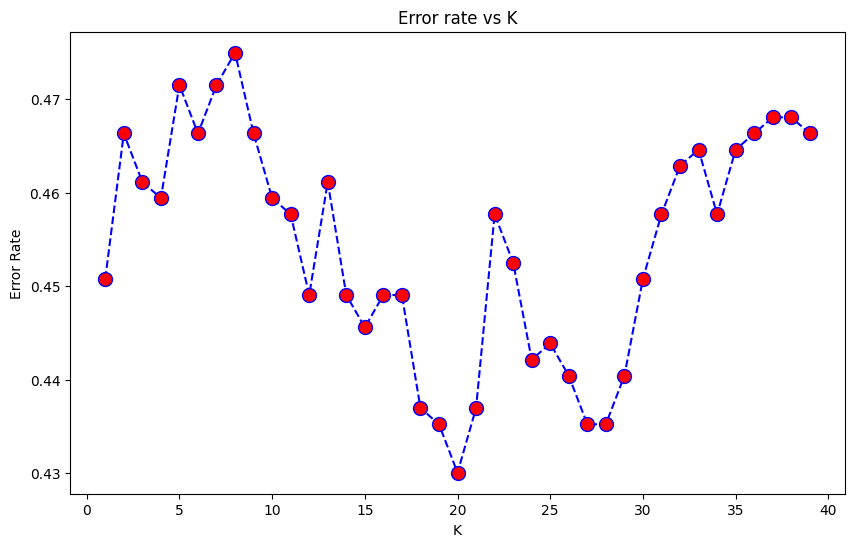

In [19]:
error_rate = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = '--', marker = 'o', markerfacecolor = 'red', markersize = 10 )
plt.title('Error rate vs K')
plt.xlabel('K')
plt.ylabel('Error Rate')

## Seems like 20 results in the least error, we use n = 20 for training the model

In [21]:
knn = KNeighborsClassifier(n_neighbors=20)

In [22]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [23]:
pred = knn.predict(X_test)

## Our model did slightly better with n = 20

In [24]:
print(confusion_matrix(y_test, pred))

[[97  0  0  3  0  0]
 [ 1 33 36 17  0 13]
 [ 1  9 65  4  0 10]
 [ 3 26 45 20  4  2]
 [ 0  0  5  0 65 30]
 [ 0  0 28  0 12 50]]


In [25]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   Classical       0.95      0.97      0.96       100
      Covers       0.49      0.33      0.39       100
        Easy       0.36      0.73      0.49        89
         Old       0.45      0.20      0.28       100
         Rap       0.80      0.65      0.72       100
         RnB       0.48      0.56      0.51        90

    accuracy                           0.57       579
   macro avg       0.59      0.57      0.56       579
weighted avg       0.59      0.57      0.56       579



In [26]:
correct_predictions = (y_test == pred).sum()
incorrect_predictions = (y_test != pred).sum()

print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {incorrect_predictions}")


Correct predictions: 330
Incorrect predictions: 249
